Đang chạy Homework 5 - Bài 1:


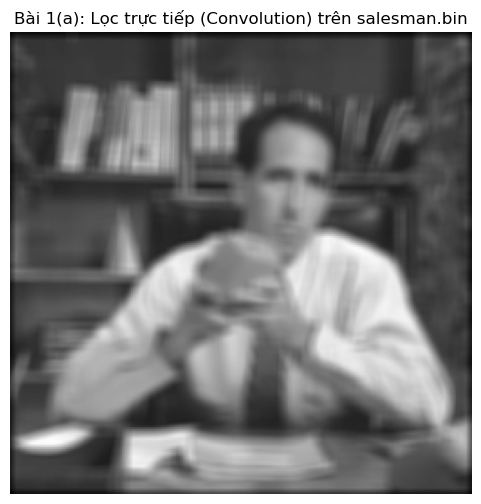

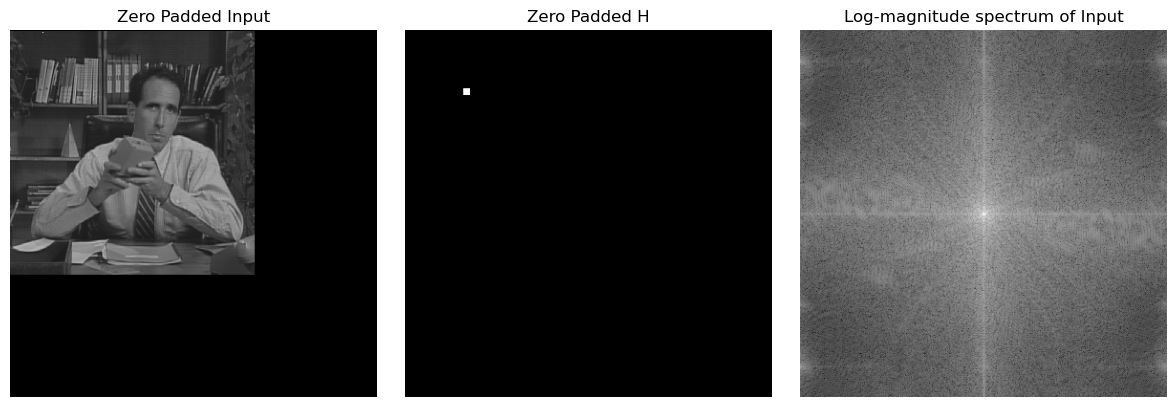

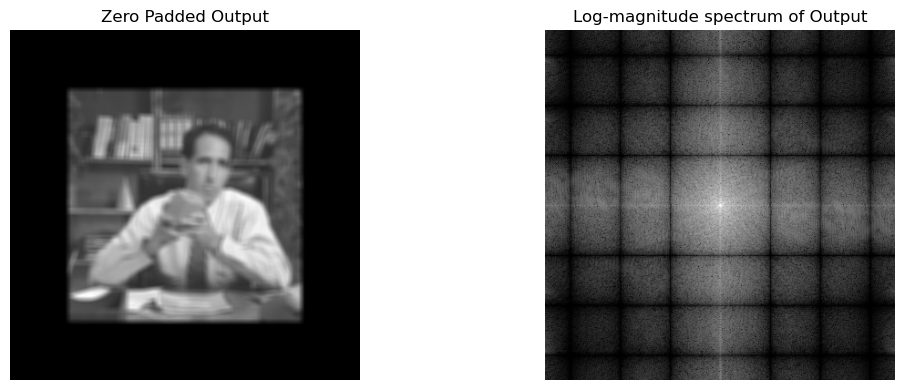

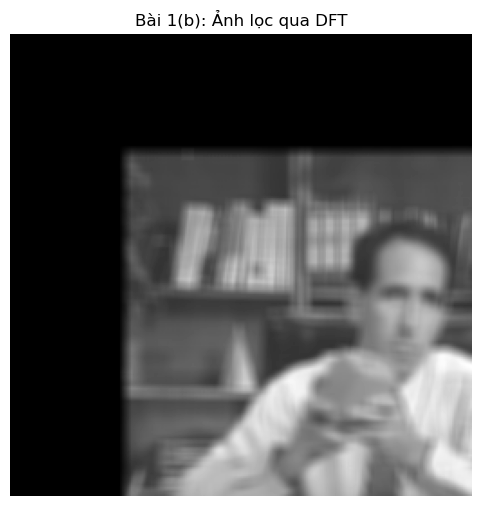

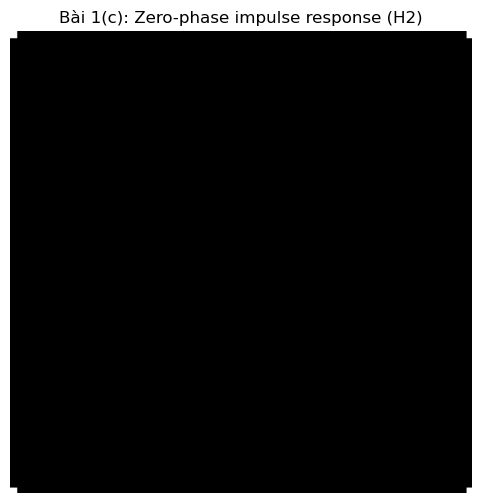

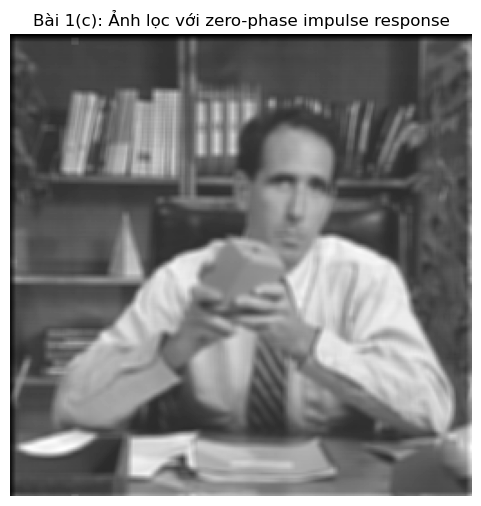

(b): max difference from part (a): 255.0000
(c): max difference from part (a): 201.6531


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Hàm đọc ảnh nhị phân từ file .bin với kích thước cho trước (256x256)
def read_bin_image(filename, shape=(256,256)):
    data = np.fromfile(filename, dtype=np.uint8)
    return data.reshape(shape)

# Hàm thực hiện full-scale contrast stretch (đưa dải ảnh về 0-255)
def contrast_stretch(image):
    imin, imax = image.min(), image.max()
    if imax > imin:
        return ((image - imin) / (imax - imin) * 255).astype(np.uint8)
    else:
        return image.astype(np.uint8)

# ------------------------ Bài 1 (a): Lọc trực tiếp trong miền không gian ------------------------
def problem1a():
    # Đọc ảnh gốc (256x256)
    img = read_bin_image("salesman.bin", (256,256)).astype(np.float32)
    
    # Zero padding: thêm 3 hàng, 3 cột ở xung quanh để tạo ảnh 262x262
    pad = 3
    padded = np.zeros((256 + 2*pad, 256 + 2*pad), dtype=np.float32)
    padded[pad:pad+256, pad:pad+256] = img
    
    # Tạo ảnh đầu ra cùng kích thước gốc
    filtered = np.zeros_like(img)
    # Bộ lọc trung bình 7x7: mỗi cửa sổ chia cho 49
    for i in range(256):
        for j in range(256):
            window = padded[i:i+7, j:j+7]
            filtered[i,j] = np.sum(window) / 49.0

    # Áp dụng full-scale contrast stretch
    filtered_stretched = contrast_stretch(filtered)
    
    # Hiển thị kết quả
    plt.figure(figsize=(6,6))
    plt.imshow(filtered_stretched, cmap='gray')
    plt.title("Bài 1(a): Lọc trực tiếp (Convolution) trên salesman.bin")
    plt.axis("off")
    plt.show()
    
    return filtered_stretched.astype(np.float32)  # trả về dạng float để so sánh sau này

# ------------------------ Bài 1 (b): Lọc qua miền tần số với nhân DFT ------------------------
def problem1b():
    # Đọc ảnh gốc (256x256)
    img = read_bin_image("salesman.bin", (256,256)).astype(np.float32)
    
    # Tạo hàm xung H của bộ lọc trung bình (7x7) trên kích thước 128x128
    H = np.zeros((128,128), dtype=np.float32)
    # Để tạo cửa sổ 7x7 có trung tâm tại H[61:68,61:68] (vì Matlab dùng 1-indexed: H(62:68,62:68) => 0-index: 61 đến 67)
    H[61:68, 61:68] = 1/49.0

    # Kích thước zero-pad:
    # Theo đề: Padsize = 256 + 128 - 1, nhưng vì FFT yêu cầu kích thước chẵn, ta chọn 384x384.
    pad_size = 384

    # Zero pad ảnh gốc (256x256) thành mảng 384x384
    ZPX = np.zeros((pad_size, pad_size), dtype=np.float32)
    ZPX[0:256, 0:256] = img  # đặt ở góc trên bên trái

    # Zero pad H (128x128) thành mảng 384x384
    ZPH = np.zeros((pad_size, pad_size), dtype=np.float32)
    ZPH[0:128, 0:128] = H

    # Tính DFT của ảnh và H
    ZPX_dft = np.fft.fft2(ZPX)
    ZPH_dft = np.fft.fft2(ZPH)

    # Để hiển thị phổ log-magnitude, căn giữa FFT
    ZPX_dft_display = np.fft.fftshift(np.log(1 + np.abs(ZPX_dft)))
    ZPH_dft_display = np.fft.fftshift(np.log(1 + np.abs(ZPH_dft)))

    # Hiển thị ảnh zero-padded và phổ của chúng (có thể hiển thị nếu cần)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(contrast_stretch(ZPX), cmap='gray')
    plt.title("Zero Padded Input")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(contrast_stretch(ZPH), cmap='gray')
    plt.title("Zero Padded H")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(contrast_stretch(ZPX_dft_display), cmap='gray')
    plt.title("Log-magnitude spectrum of Input")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Thực hiện nhân điểm (pointwise multiplication) trong miền tần số
    ZPY_dft = ZPX_dft * ZPH_dft

    # Tính inverse FFT để thu được ảnh đã lọc
    ZPY = np.fft.ifft2(ZPY_dft).real

    # Hiển thị phổ log-magnitude của kết quả (căn giữa)
    ZPY_dft_display = np.fft.fftshift(np.log(1 + np.abs(ZPY_dft)))
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(contrast_stretch(ZPY), cmap='gray')
    plt.title("Zero Padded Output")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(contrast_stretch(ZPY_dft_display), cmap='gray')
    plt.title("Log-magnitude spectrum of Output")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Crop kết quả để lấy ảnh 256x256 (giả sử crop từ góc trên bên trái)
    Y1b = ZPY[0:256, 0:256]
    Y1b_stretched = contrast_stretch(Y1b)

    plt.figure(figsize=(6,6))
    plt.imshow(Y1b_stretched, cmap='gray')
    plt.title("Bài 1(b): Ảnh lọc qua DFT")
    plt.axis("off")
    plt.show()

    return Y1b.astype(np.float32)

# ------------------------ Bài 1 (c): Lọc qua miền tần số với impulse response zero-phase ------------------------
def problem1c():
    # Đọc ảnh gốc (256x256)
    img = read_bin_image("salesman.bin", (256,256)).astype(np.float32)
    
    # Tạo hàm xung H ban đầu kích thước 256x256, tất cả phần tử bằng 0
    H = np.zeros((256,256), dtype=np.float32)
    # Đặt cửa sổ 7x7 tại vị trí từ 125 đến 131 (0-indexed: tương đương với H(126:132) trong Matlab)
    H[125:132, 125:132] = 1/49.0

    # Lấy impulse response zero-phase: sử dụng fftshift để dịch chuyển H
    H2 = np.fft.fftshift(H)
    
    # Hiển thị H2 (zero-phase impulse response) với full-scale contrast
    plt.figure(figsize=(6,6))
    plt.imshow(contrast_stretch(H2), cmap='gray')
    plt.title("Bài 1(c): Zero-phase impulse response (H2)")
    plt.axis("off")
    plt.show()

    # Zero pad cả ảnh gốc và H2 đến kích thước 512x512
    pad_size = 512
    ZPX = np.zeros((pad_size, pad_size), dtype=np.float32)
    ZPX[0:256, 0:256] = img
    ZPH2 = np.zeros((pad_size, pad_size), dtype=np.float32)
    ZPH2[0:256, 0:256] = H2

    # Tính FFT của ảnh và H2 (không cần căn giữa vì chúng ta sẽ thực hiện nhân)
    ZPX_dft = np.fft.fft2(ZPX)
    ZPH2_dft = np.fft.fft2(ZPH2)

    # Nhân điểm trong miền tần số
    ZPY_dft = ZPX_dft * ZPH2_dft

    # Tính inverse FFT
    ZPY = np.fft.ifft2(ZPY_dft).real

    # Crop ra ảnh kết quả 256x256 (lấy phần góc trên bên trái)
    Y1c = ZPY[0:256, 0:256]
    Y1c_stretched = contrast_stretch(Y1c)

    plt.figure(figsize=(6,6))
    plt.imshow(Y1c_stretched, cmap='gray')
    plt.title("Bài 1(c): Ảnh lọc với zero-phase impulse response")
    plt.axis("off")
    plt.show()

    return Y1c.astype(np.float32)

# ------------------------ Chương trình chính cho Bài 1 ------------------------
if __name__ == '__main__':
    print("Đang chạy Homework 5 - Bài 1:")
    # Phần (a)
    Y1a = problem1a()
    # Phần (b)
    Y1b = problem1b()
    # Phần (c)
    Y1c = problem1c()

    # So sánh max difference giữa các kết quả
    diff_b_a = np.abs(Y1b - Y1a).max()
    diff_c_a = np.abs(Y1c - Y1a).max()
    print(f"(b): max difference from part (a): {diff_b_a:.4f}")
    print(f"(c): max difference from part (a): {diff_c_a:.4f}")
